# Why This Project Is Made ?
* This project detects violent content in videos streamed through set-top box systems, aiming to block harmful scenes and protect young viewers.


* I used MobileViT for frame-based classification to ensure efficiency on low-resource devices.  


* The focus is on real-time analysis while balancing accuracy, speed, and memory usage.


# Setup Details
* This notebook is created on Google Colab and is configured to run on a CPU-only environment (with no GPU support) to simulate low-resource conditions.

* This setup is useful for testing the model’s performance (inference time, memory consumption) under limited computational resources, which is essential for eventual deployment on devices with constrained hardware (e.g., set-top boxes or IoT devices).

* **System Requirements:** A CPU-enabled environment is used in this notebook. While a GPU-enabled setup generally speeds up training and inference, running on CPU allows us to evaluate the model's performance in lower-resource conditions.

# Step 1
# Importing The Libraries
We are first importing all the required libraries.

In [ ]:
import os  # Provides functions to interact with the operating system (e.g., file paths).
from glob import glob  # Finds all file paths matching a specified pattern.
import torch  # Core PyTorch library for tensor operations and model building.
from torch.utils.data import Dataset, DataLoader  # Custom dataset and batch loading utilities in PyTorch.
import torchvision.transforms as transforms  # Image transformation utilities (e.g., resizing, normalization).
from PIL import Image  # Opens and processes image files using the Python Imaging Library.
import cv2 as cv  # OpenCV library for image and video processing.
import random  # Generates random numbers or selections (e.g., for data shuffling).
import numpy as np  # Supports large, multi-dimensional arrays and matrices with mathematical functions.
import pandas as pd  # Data analysis and manipulation tool using dataframes.
import time  # Provides time-related functions (e.g., measuring execution time).
import tracemalloc  # Tracks memory allocations for debugging memory usage.
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets.
from transformers import AutoImageProcessor, AutoConfig, MobileViTForImageClassification  # Hugging Face modules for image preprocessing, model configuration, and MobileViT model.
import zipfile  # Extracts and handles ZIP compressed files.
from torch.optim import AdamW  # AdamW optimizer for training deep learning models.
from tqdm import tqdm  # Displays a progress bar for loops.
import cv2  # Duplicate import; same as `import cv2 as cv`.
import csv  # Reads and writes CSV (Comma Separated Values) files.
from IPython.display import HTML  # Displays HTML content in Jupyter or Colab notebooks.
from base64 import b64encode  # Encodes binary data into base64 (e.g., for embedding files).
import shutil  # Performs file operations like copy, move, or delete.
from google.colab import files  # Facilitates file upload/download in Google Colab.


# Step 2
# Collecting Data From Kaggle Through Kaggle API

In [ ]:
!pip install kaggle

In [ ]:
# upload kaggle.json file
# configuring the path of kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
100% 3.58G/3.58G [01:32<00:00, 37.3MB/s]
100% 3.58G/3.58G [01:34<00:00, 40.7MB/s]


In [ ]:
# import zipfile
dataset = '/content/real-life-violence-situations-dataset.zip'
with zipfile.ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted.")

The dataset is extracted.


In [ ]:
# Replace this with the actual dataset path
dataset_path = "/content/real life violence situations"

for root, dirs, files in os.walk(dataset_path):
    print(f"Current Directory: {root}")
    for d in dirs:
        print(f"  └── Subfolder: {d}")


Current Directory: /content/real life violence situations
  └── Subfolder: Real Life Violence Dataset
Current Directory: /content/real life violence situations/Real Life Violence Dataset
  └── Subfolder: Violence
  └── Subfolder: NonViolence
Current Directory: /content/real life violence situations/Real Life Violence Dataset/Violence
Current Directory: /content/real life violence situations/Real Life Violence Dataset/NonViolence


# Step 3
# Extracting All The Frames From The Video
Defining a function named extract_all_video_frames() to extract all the video frames by skipping every 10 frames and saving them in the extract_frames folder.


In [ ]:
def extract_all_video_frames(video_root_dir, output_root_dir, frame_skip=10): # Extract frames skipping every 10 frames
    for label_folder in ["Violence", "NonViolence"]: # Loop through both class folders
        print(f"Processing folder: {label_folder}")
        input_folder = os.path.join(video_root_dir, label_folder)
        output_folder = os.path.join(output_root_dir, label_folder)
        os.makedirs(output_folder, exist_ok=True)

        for filename in os.listdir(input_folder):
            if filename.lower().endswith((".avi", ".mp4")):  # it handles both formats
                video_path = os.path.join(input_folder, filename)
                cap = cv.VideoCapture(video_path)
                frame_idx = 0
                saved = 0

                while cap.isOpened():
                    ret, frame = cap.read() # Read frame-by-frame
                    if not ret:
                        break # Exit if no more frames
                    if frame_idx % frame_skip == 0: # Save only every nth frame
                        base = os.path.splitext(filename)[0]  # Remove file extension
                        frame_name = f"{base}_frame{frame_idx}.jpg" # Name frame image
                        cv.imwrite(os.path.join(output_folder, frame_name), frame)  # Save frame as image
                        saved += 1
                    frame_idx += 1
                cap.release()
                print(f"Extracted {saved} frames from {filename} → {output_folder}")


In [ ]:
video_dir = "/content/real life violence situations/Real Life Violence Dataset" # Directory Containing The Videos
output_dir = "/content/extracted_frames" # The output directory


In [ ]:
extract_all_video_frames(video_dir, output_dir, frame_skip=10)  # Calling The function to extract the frames.


Processing folder: Violence
Extracted 15 frames from V_750.mp4 → /content/extracted_frames/Violence
Extracted 11 frames from V_243.mp4 → /content/extracted_frames/Violence
Extracted 19 frames from V_571.mp4 → /content/extracted_frames/Violence
Extracted 16 frames from V_205.mp4 → /content/extracted_frames/Violence
Extracted 14 frames from V_333.mp4 → /content/extracted_frames/Violence
Extracted 16 frames from V_238.mp4 → /content/extracted_frames/Violence
Extracted 11 frames from V_164.mp4 → /content/extracted_frames/Violence
Extracted 13 frames from V_766.mp4 → /content/extracted_frames/Violence
Extracted 15 frames from V_482.mp4 → /content/extracted_frames/Violence
Extracted 19 frames from V_592.mp4 → /content/extracted_frames/Violence
Extracted 13 frames from V_681.mp4 → /content/extracted_frames/Violence
Extracted 13 frames from V_473.mp4 → /content/extracted_frames/Violence
Extracted 16 frames from V_954.mp4 → /content/extracted_frames/Violence
Extracted 16 frames from V_239.mp4 →

# Step 4
# Defining The Labeling Function assign_label()
Now we define a function named **assign_label** that extracts the parent folder name from each file path and assigns a label (for example, **0 for "non-violent"** video frames and **1 for "violent"** video frames").

In [ ]:
def assign_label(path):
    parent_folder = os.path.basename(os.path.dirname(path)).lower()
    if parent_folder == "violence":
        return 1
    elif parent_folder == "nonviolence":
        return 0
    else:
        raise ValueError(f"Unexpected label folder: {parent_folder}")
# Quick test to ensure the function works:

sample_path = "/content/extracted_frames/NonViolence/NV_863_frame50.jpg"
print("Sample label:", assign_label(sample_path))


Sample label: 0


# Step 5
# Applying The Function On All The Extracted Frames
Now we are collecting all the frames paths from the extracted_frames folder and applying the assigning label function on them. Also printing the no of frames found in the folder.

In [ ]:
# Collect all frame image paths
all_frame_paths = glob("/content/extracted_frames/*/*.jpg")

# Assign labels based on folder name
all_labels = [assign_label(path) for path in all_frame_paths]

print(f"Total frames found: {len(all_frame_paths)}")
print(f"Labels (sample): {all_labels[:10]}")

Total frames found: 29569
Labels (sample): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Step 6
# Train-Test Split
We are now splitting the data into train dataset and test dataset.

In [ ]:
# Collect all frame paths
# data_dir = "/content/extracted_frames"
# all_frame_paths = glob(os.path.join(data_dir, "*/*.jpg"))


# # Step 2: Generate labels based on parent folder name
# all_labels = [assign_label(path) for path in all_frame_paths]

# Split into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_frame_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

print(f"Found {len(train_paths)} training frames.")
print(f"Found {len(test_paths)} testing frames.")


Found 23655 training frames.
Found 5914 testing frames.


# Step 7
# Load the Pre-Trained Model and Reconfigure the Classification Head
We load the pre-trained MobileViT model from Hugging Face. We create a configuration that sets num_labels=2, and we use the flag ignore_mismatched_sizes=True to skip loading the classifier head (since it was originally set for a larger number of classes).

In [ ]:
# Load the processor and model.
processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

# Create a configuration with 2 output labels. Since we're working with two classes: 'Violence' and 'NonViolence'
config = AutoConfig.from_pretrained("apple/mobilevit-small", num_labels=2)

# Load the MobileViT model for image classification with the new configuration.
model = MobileViTForImageClassification.from_pretrained(
    "apple/mobilevit-small",
    config=config,
    ignore_mismatched_sizes=True  # Overwrites the pretrained classifier head.
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([2, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Step 8
# Create A ViolenceDataset Class
This dataset class loads a video frame, applies basic PyTorch transforms (resizing and tensor conversion), then converts the tensor back to a NumPy array in [0, 255] uint8 format. This is done to ensure compatibility with the Hugging Face processor, which expects standard PIL images. The processor then normalizes and formats the image for the model. The method returns the processed image tensor and its corresponding label.

In [ ]:
class ViolenceDataset(Dataset):
    def __init__(self, frame_paths, labels, processor):
        self.frame_paths = frame_paths
        self.labels = labels
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        frame = Image.open(self.frame_paths[idx]).convert("RGB")
        frame_tensor = self.transform(frame)

        np_frame = (frame_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
        pil_frame = Image.fromarray(np_frame).convert("RGB")

        processed = self.processor(images=pil_frame, return_tensors="pt")
        input_tensor = processed["pixel_values"][0]

        label = torch.tensor(self.labels[idx], dtype=torch.int64)
        return input_tensor, label

# Step 9
# Defining The Train Dataset and Test Dataset Path

In [ ]:
train_dataset = ViolenceDataset(train_paths, train_labels, processor)
test_dataset = ViolenceDataset(test_paths, test_labels, processor)


# Step 10
# Defining The train_loader and test_loader
Train and test DataLoaders are used to efficiently feed batches of data to the model, the train loader is used during training to update model weights, while the test loader is used to evaluate model performance without updating weights.
`train_loader` loads shuffled batches for training (with weight updates).  
`test_loader` loads fixed-order batches for evaluation (no weight updates).

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
# verifying the batch structure
for images, labels in train_loader:
    print("Batch shape:", images.shape, "| Labels:", labels[:8])
    break


Batch shape: torch.Size([8, 3, 256, 256]) | Labels: tensor([1, 1, 1, 0, 1, 1, 1, 0])


# Step 11
# Device, Loss Function, and Optimizer Initialization.

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
device = torch.device("cpu")
model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)


# Step 12
# Defining The Model Training Function
The train_two_epoch() function trains the model for two epochs using the training dataloader by performing forward passes, computing loss, backpropagating gradients, and updating model weights. It returns the average loss and accuracy for the epoch.

In [ ]:
def train_two_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits # forward pass,  Computes predictions from input images.
        loss = criterion(outputs, labels) # loss computation,  Measures how wrong the predictions are.

        optimizer.zero_grad() # gradient zeroing, Clears old gradients to prevent accumulation.
        loss.backward() # backpropagation, Computes gradients of the loss w.r.t. model parameters.
        optimizer.step() # weight update, Updates model parameters to reduce the loss.

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total # calculating accuracy
    avg_loss = total_loss / len(dataloader) # calculating average loss
    return avg_loss, accuracy


# Step 13
# Defining The Model Evaluation Function
This function evaluates the model on validation/test data without updating weights. It disables gradient computation for efficiency and calculates average loss and accuracy.

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval() # Set model to evaluation mode
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():  # Disable gradient computation to save memory and speed up
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device) # Move data to device (CPU/GPU)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()  # Accumulate loss for averaging
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0) # Total number of samples

    accuracy = 100 * correct / total # Compute accuracy in percentage
    avg_loss = total_loss / len(dataloader)  # Compute average loss over all batches
    return avg_loss, accuracy


In [ ]:
# runs training and evaluation for 2 epochs, printing loss and accuracy after each:
for epoch in range(2):
    print(f"\nEpoch {epoch + 1}")
    train_loss, train_acc = train_two_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

    val_loss, val_acc = evaluate(model, test_loader, criterion)
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")



Epoch 1


Training:   0%|          | 0/2957 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

Training: 100%|██████████| 2957/2957 [4:12:08<00:00,  5.12s/it]


Train Loss: 0.1802 | Train Acc: 93.36%


Evaluating: 100%|██████████| 740/740 [14:47<00:00,  1.20s/it]


Val   Loss: 0.0504 | Val   Acc: 98.41%

Epoch 2


Training: 100%|██████████| 2957/2957 [3:22:49<00:00,  4.12s/it]


Train Loss: 0.0596 | Train Acc: 98.09%


Evaluating: 100%|██████████| 740/740 [14:47<00:00,  1.20s/it]

Val   Loss: 0.0398 | Val   Acc: 98.68%


# Step 14
#  Video Inference Function
This function infer_video() performs frame-by-frame prediction on a video using a trained model. It skips frames for faster processing, applies necessary preprocessing, collects predictions, and measures inference time and memory usage.

In [ ]:
def infer_video(video_path, model, processor, frame_skip=10, device="cpu"):
    model.eval()
    model.to(device)

    cap = cv2.VideoCapture(video_path)  # Open video file
    predictions = []
    frame_idx = 0

    # Get video duration in milliseconds
# Duration = Total Frames / FPS → converted to ms
# 'if fps else 0' prevents division by zero if FPS info is missing or unreadable
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration_ms = (frame_count / fps) * 1000 if fps else 0

    tracemalloc.start()  # Start memory tracking
    start_time = time.perf_counter()  # Start timing

    with torch.no_grad():  # Disable gradient tracking for inference
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frame_skip == 0:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil = Image.fromarray(rgb).convert("RGB")
                processed = processor(images=pil, return_tensors="pt")["pixel_values"].to(device)
                logits = model(processed).logits
                pred = torch.argmax(logits, dim=1).item()
                predictions.append(pred)
            frame_idx += 1

    cap.release()
    end_time = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    total_memory_used = current / (1024 * 1024)  # Convert to MB
    elapsed_time = (end_time - start_time) * 1000  # Convert to ms

    return {
        "video_name": os.path.basename(video_path),
        "frames_processed": len(predictions),
        "inference_time_ms": round(elapsed_time, 2),
        "memory_used_MB": round(total_memory_used, 2),
        "duration_ms": round(duration_ms, 2)  # Duration in ms
    }


# Step 15
# Run Inference Benchmark on Video Dataset

This block benchmarks inference performance (time and memory) on all videos in the Violence/NonViolence dataset using the trained model. Results are saved as a CSV for analysis.


In [ ]:

import glob
video_root = "/content/real life violence situations/Real Life Violence Dataset"
csv_output = "/content/inference_benchmark.csv"
device = "cpu"
frame_skip = 10  # Skip every 10 frames to speed up inference

# Get all video paths from both classes
video_paths = glob.glob(os.path.join(video_root, "Violence", "*")) + \
              glob.glob(os.path.join(video_root, "NonViolence", "*"))

results = []

# Loop through each video and run inference
for path in video_paths:
    if path.lower().endswith((".avi", ".mp4")):
        print(f"Benchmarking: {os.path.basename(path)}")
        stats = infer_video(path, model, processor, frame_skip=frame_skip, device=device)
        results.append(stats)

# Sort results by memory usage (optional)
results.sort(key=lambda x: x["memory_used_MB"])

# Save results to CSV
with open(csv_output, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print(f"Inference benchmarking complete. CSV saved at: {csv_output}")

Benchmarking: V_750.mp4
Benchmarking: V_243.mp4
Benchmarking: V_571.mp4
Benchmarking: V_205.mp4
Benchmarking: V_333.mp4
Benchmarking: V_238.mp4
Benchmarking: V_164.mp4
Benchmarking: V_766.mp4
Benchmarking: V_482.mp4
Benchmarking: V_592.mp4
Benchmarking: V_681.mp4
Benchmarking: V_473.mp4
Benchmarking: V_954.mp4
Benchmarking: V_239.mp4
Benchmarking: V_769.mp4
Benchmarking: V_553.mp4
Benchmarking: V_780.mp4
Benchmarking: V_416.mp4
Benchmarking: V_233.mp4
Benchmarking: V_467.mp4
Benchmarking: V_601.mp4
Benchmarking: V_503.mp4
Benchmarking: V_501.mp4
Benchmarking: V_360.mp4
Benchmarking: V_107.mp4
Benchmarking: V_209.mp4
Benchmarking: V_621.mp4
Benchmarking: V_539.mp4
Benchmarking: V_720.mp4
Benchmarking: V_617.mp4
Benchmarking: V_831.mp4
Benchmarking: V_692.mp4
Benchmarking: V_449.mp4
Benchmarking: V_342.mp4
Benchmarking: V_427.mp4
Benchmarking: V_215.mp4
Benchmarking: V_69.mp4
Benchmarking: V_742.mp4
Benchmarking: V_951.mp4
Benchmarking: V_984.mp4
Benchmarking: V_50.mp4
Benchmarking: V_18

# Step 16
# Sorting The Inference_Benchmark CSV File

In [ ]:
# Load the CSV file
df = pd.read_csv("/content/inference_benchmark.csv")

# Extract numeric values from the video names and sort them
df_sorted = df.sort_values(by="video_name", key=lambda x: x.str.extract(r"(\d+)")[0].astype(float))

# Save the sorted CSV
df_sorted.to_csv("/content/sorted_inference_benchmark.csv", index=False)

# Display the first few rows to confirm sorting
print(df_sorted.head())



     video_name  frames_processed  inference_time_ms  memory_used_MB  \
1970    V_1.mp4                11            3069.93            6.70   
1980   NV_1.mp4                 7            2596.02            6.70   
1977    V_2.mp4                12            3397.40            6.70   
152    NV_2.mp4                13            1996.18            0.91   
1879   NV_3.mp4                13            2645.54            3.41   

      duration_ms  
1970      6681.30  
1980      2650.56  
1977      6900.00  
152       5000.00  
1879      5120.00  


# Step 17
# Model Evaluation on Test Set – Accuracy and Classification Report

Computes the model's prediction accuracy on the test dataset and generates a detailed classification report showing precision, recall, and F1-score for each class.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cpu")  # or "cuda" if using GPU, "cpu" for using CPU
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())


In [ ]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NonViolence", "Violence"]))


Test Accuracy: 98.68%

Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.99      0.98      0.99      2636
    Violence       0.98      1.00      0.99      3278

    accuracy                           0.99      5914
   macro avg       0.99      0.99      0.99      5914
weighted avg       0.99      0.99      0.99      5914



# Step 18
# Interactive Video Inference and Display

This code randomly selects a video from the dataset, performs inference using the trained model, and then either blocks the video (if predicted violent) or plays it inline in the notebook (if predicted as non-violent) . It uses styled HTML for user-friendly display.


In [ ]:

#  Display the blocked warning as a styled HTML banner

def show_blocked_html_warning():
    return HTML("""
    <link href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css" rel="stylesheet">
    <div style="padding: 20px; background-color: red; border-radius: 10px; text-align: center; font-size: 18px; color: white;">
        <i class="fa-solid fa-ban" style="font-size: 20px; vertical-align: middle; margin-right: 8px;"></i>
        <strong>Warning:</strong> This video has been blocked due to violent content.
    </div>
    """)


#  Display a video inline in notebooks (for safe content)
def play_video_inline(video_path):
    with open(video_path, 'rb') as f:
        mp4 = f.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""<video width=400 controls><source src="{data_url}" type="video/mp4"></video>""")

#  Core logic to select a random video, run inference, and block or play
def check_video_and_show(video_root, model, processor, frame_skip=10, device="cpu"):
    # Randomly select a video
    video_paths = glob.glob(os.path.join(video_root, "Violence", "*")) + \
                  glob.glob(os.path.join(video_root, "NonViolence", "*"))
    video_paths = [p for p in video_paths if p.lower().endswith((".avi", ".mp4"))]

    selected_video = random.choice(video_paths)
    print(f"\n Selected video: {selected_video}")

    # Inference on sampled frames
    preds = []
    cap = cv2.VideoCapture(selected_video)
    frame_idx = 0

    model.eval()
    model.to(device)

    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frame_skip == 0:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil = Image.fromarray(rgb).convert("RGB")
                processed = processor(images=pil, return_tensors="pt")["pixel_values"].to(device)
                logits = model(processed).logits
                pred = torch.argmax(logits, dim=1).item()
                preds.append(pred)
            frame_idx += 1
    cap.release()

    #  Decide and respond
    final_prediction = 1 if preds.count(1) > preds.count(0) else 0

    if final_prediction == 1:
        return show_blocked_html_warning()
    else:
        return play_video_inline(selected_video)


In [ ]:
video_root = "/content/real life violence situations/Real Life Violence Dataset"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model.to(device)
check_video_and_show(video_root, model, processor, frame_skip=10, device=device)



 Selected video: /content/real life violence situations/Real Life Violence Dataset/Violence/V_890.mp4


In [ ]:
video_root = "/content/real life violence situations/Real Life Violence Dataset"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu")
model.to(device)
check_video_and_show(video_root, model, processor, frame_skip=10, device=device)



 Selected video: /content/real life violence situations/Real Life Violence Dataset/NonViolence/NV_94.mp4


# Step 19
# Calculating Averages Of Inference Time Per Video & Memory Used Per Video

In [ ]:
df = pd.read_csv("/content/inference_benchmark.csv")

# Compute averages
avg_inference_time_per_video = round(df["inference_time_ms"].mean(), 2)
avg_memory_used_per_video = round(df["memory_used_MB"].mean(), 2)

print(f"Average Inference Time per Video: {avg_inference_time_per_video} milliseconds")
print(f"Average Memory Used per Video: {avg_memory_used_per_video} MB")


Average Inference Time per Video: 2759.3 milliseconds
Average Memory Used per Video: 1.58 MB


# Step 20
# Computing Averages Of Inference Time Per Frame & Memory Used Per Frame

In [ ]:
df["inference_time_per_frame"] = df["inference_time_ms"] / df["frames_processed"]
df["memory_used_per_frame"] = df["memory_used_MB"] / df["frames_processed"]

avg_inference_time_per_frame = round(df["inference_time_per_frame"].mean(), 4)
avg_memory_used_per_frame = round(df["memory_used_per_frame"].mean(), 4)

print(f"Average Inference Time per Frame: {avg_inference_time_per_frame} milliseconds")
print(f"Average Memory Used per Frame: {avg_memory_used_per_frame} MB")


Average Inference Time per Frame: 184.2521 milliseconds
Average Memory Used per Frame: 0.1199 MB


# Step 21
# Download The Trained Model

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/mobilevit_trained.pth")
import os
print(os.listdir("/content/"))  # This should show "mobilevit_trained.pth"
from google.colab import files
files.download("/content/mobilevit_trained.pth")



['.config', 'mobilevit_trained.pth', 'valid_video_list.txt', 'inference_benchmark.csv', 'sorted_inference_benchmark.csv', 'real-life-violence-situations-dataset.zip', 'extracted_frames', 'kaggle.json', 'Real Life Violence Dataset', 'real life violence situations', 'sample_data']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv("/content/inference_benchmark.csv")




# Step 22
# Inference Time Distribution

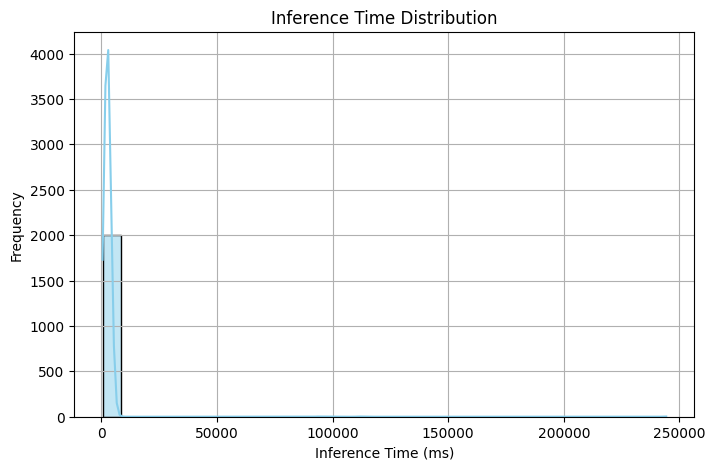

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["inference_time_ms"], bins=30, kde=True, color="skyblue")
plt.title("Inference Time Distribution")
plt.xlabel("Inference Time (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


95th percentile of inference time: 3792.00 milliseconds


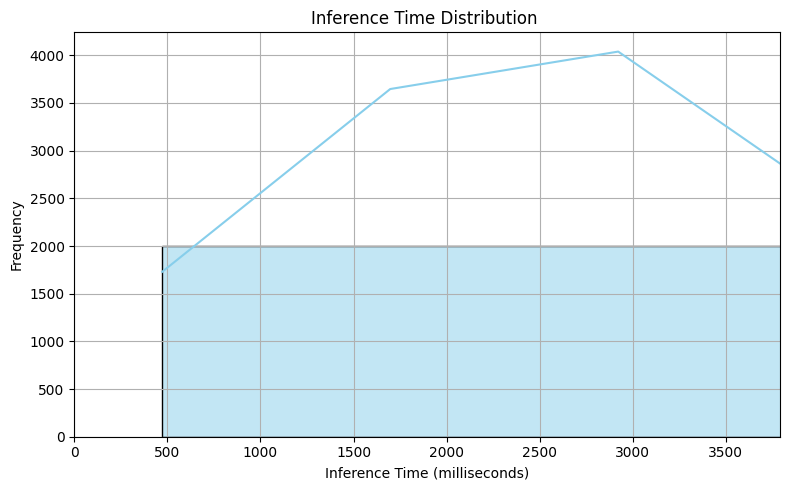

In [ ]:
# Calculate the 95th percentile for inference time in ms
threshold_ms = df["inference_time_ms"].quantile(0.95)
print(f"95th percentile of inference time: {threshold_ms:.2f} milliseconds")
# Plot histogram with x-axis limited to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df["inference_time_ms"], bins=30, kde=True, color="skyblue")
plt.title("Inference Time Distribution ")
plt.xlabel("Inference Time (milliseconds)")
plt.ylabel("Frequency")
plt.xlim(0, threshold_ms)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate mean and variance of inference time
mean_inference = df["inference_time_ms"].mean()
variance_inference = df["inference_time_ms"].var()

print(f"Mean Inference Time: {mean_inference:.2f} ms")
print(f"Variance of Inference Time: {variance_inference:.2f} ms²")


Mean Inference Time: 2759.30 ms
Variance of Inference Time: 39898379.52 ms²


# Step 23
# Memory Usage Distribution

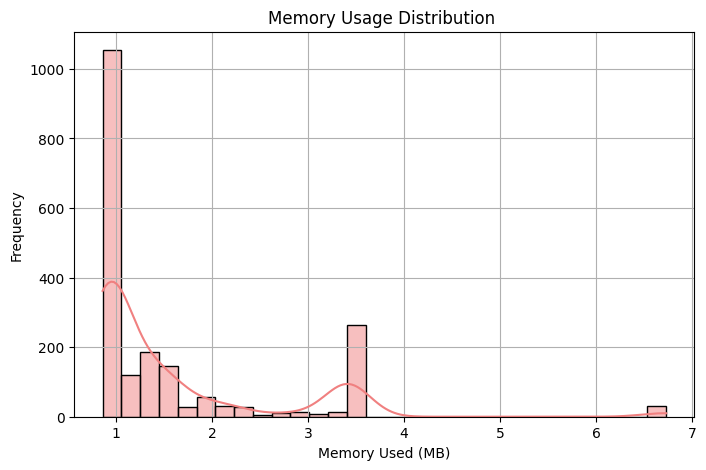

In [ ]:
# 1. Full Range - Memory Usage
plt.figure(figsize=(8, 5))
sns.histplot(df["memory_used_MB"], bins=30, kde=True, color="lightcoral")
plt.title("Memory Usage Distribution ")
plt.xlabel("Memory Used (MB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

95th percentile of memory usage: 3.42 MB


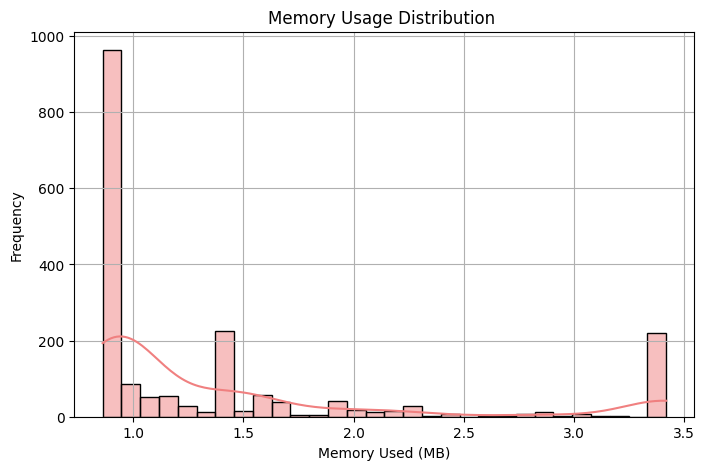

In [ ]:
# Calculate the 95th percentile for memory usage
threshold_mem = df["memory_used_MB"].quantile(0.95)
print(f"95th percentile of memory usage: {threshold_mem:.2f} MB")

# Plot memory usage up to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df[df["memory_used_MB"] <= threshold_mem]["memory_used_MB"],
             bins=30, kde=True, color="lightcoral")
plt.title("Memory Usage Distribution ")
plt.xlabel("Memory Used (MB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# Calculate mean and variance of memory usage
mean_memory = df["memory_used_MB"].mean()
variance_memory = df["memory_used_MB"].var()

print(f"Mean Memory Usage: {mean_memory:.2f} MB")
print(f"Variance of Memory Usage: {variance_memory:.2f} MB²")


Mean Memory Usage: 1.58 MB
Variance of Memory Usage: 1.15 MB²


# Step 24
# Frames Processed Distribution

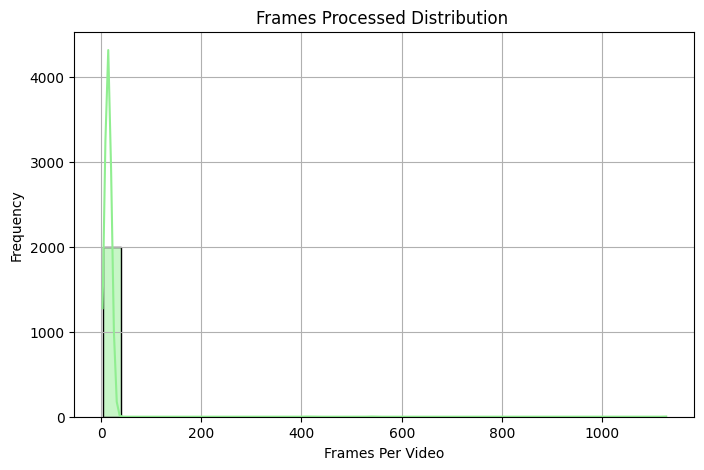

In [ ]:
# 1. Full Range - Frames Processed
plt.figure(figsize=(8, 5))
sns.histplot(df["frames_processed"], bins=30, kde=True, color="lightgreen")
plt.title("Frames Processed Distribution ")
plt.xlabel("Frames Per Video")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

95th percentile of frames processed: 19


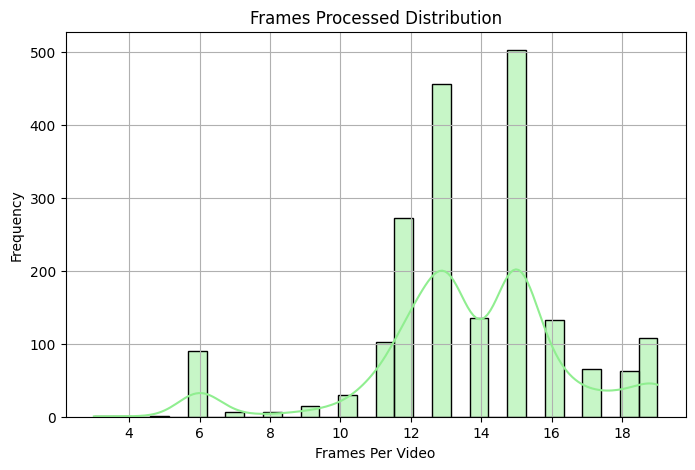

In [ ]:
# Calculate the 95th percentile for frames processed
threshold_frames = df["frames_processed"].quantile(0.95)
print(f"95th percentile of frames processed: {threshold_frames:.0f}")

# Plot frames processed up to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df[df["frames_processed"] <= threshold_frames]["frames_processed"],
             bins=30, kde=True, color="lightgreen")
plt.title("Frames Processed Distribution")
plt.xlabel("Frames Per Video")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# Calculate mean and variance of frames processed
mean_frames = df["frames_processed"].mean()
variance_frames = df["frames_processed"].var()

print(f"Mean Frames Processed: {mean_frames:.2f}")
print(f"Variance of Frames Processed: {variance_frames:.2f}")


Mean Frames Processed: 14.78
Variance of Frames Processed: 845.48


# Step 25
# Distribution of Video Range

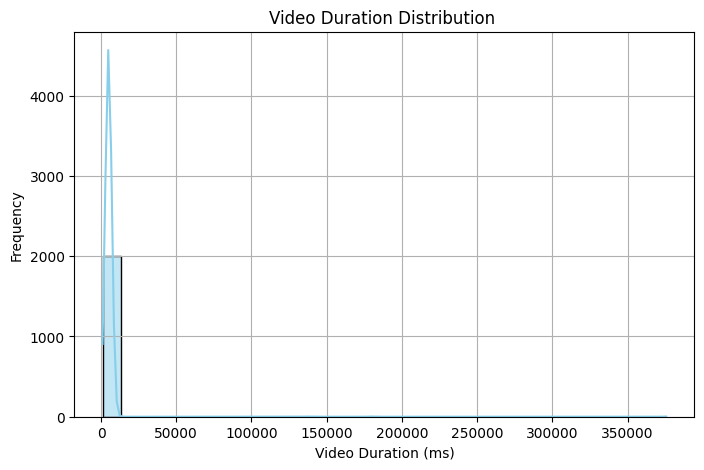

In [ ]:
# Plot full range of video duration
plt.figure(figsize=(8, 5))
sns.histplot(df["duration_ms"], bins=30, kde=True, color="skyblue")
plt.title("Video Duration Distribution ")
plt.xlabel("Video Duration (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


95th percentile of video duration: 5800 ms


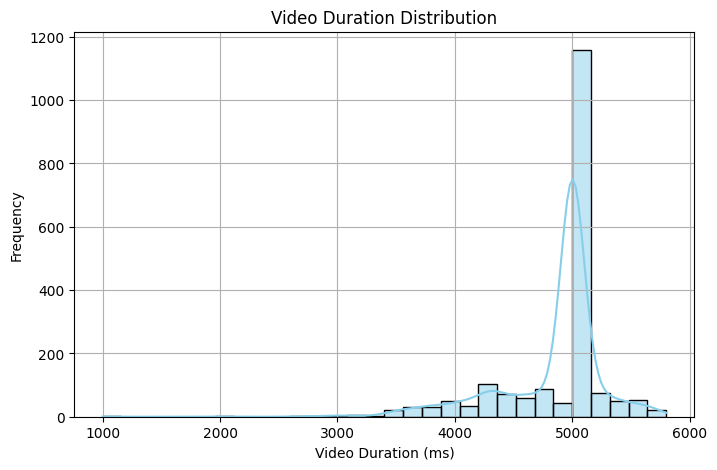

In [ ]:
# Calculate the 95th percentile for video duration
threshold_duration = df["duration_ms"].quantile(0.95)
print(f"95th percentile of video duration: {threshold_duration:.0f} ms")

# Plot video duration up to the 95th percentile
plt.figure(figsize=(8, 5))
sns.histplot(df[df["duration_ms"] <= threshold_duration]["duration_ms"],
             bins=30, kde=True, color="skyblue")
plt.title("Video Duration Distribution")
plt.xlabel("Video Duration (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# Calculate mean and variance of video duration
mean_duration = df["duration_ms"].mean()
variance_duration = df["duration_ms"].var()

print(f"Mean Video Duration: {mean_duration:.2f} ms")
print(f"Variance of Video Duration: {variance_duration:.2f} ms²")


Mean Video Duration: 5252.81 ms
Variance of Video Duration: 93034171.96 ms²


# Step 26
# Zipping The Extracted Frames Folder

In [ ]:
# Define the directory you want to download
output_dir = "/content/extracted_frames"

# Create a zip file of the directory
shutil.make_archive(output_dir, 'zip', output_dir)

# Download the zipped file
# files.download(output_dir + ".zip")


'/content/extracted_frames.zip'

# The End